# Initialize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
from IPython.display import display, Math
from matplotlib.ticker import StrMethodFormatter, PercentFormatter
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import shift
from scipy.constants import c, pi
from pandas import DataFrame

import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.backend.operators import compute_velocity, compute_position, compute_objective_function
from pyswarms.backend.handlers import VelocityHandler, BoundaryHandler

from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

import sys
sys.path.append('../../python')

from Functions import *
from Classes import *

versions = ['v202','v221','v231','v242']  # Lumerical versions in this scope

try:
    print('imp module found!')
    import imp
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py')
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')

except:
    print('imp module not found. Trying with importlib...')
    from importlib.machinery import SourceFileLoader
    print('found!')
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py').load_module()
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')

from lumapi import LumApiError

plt.rcParams["figure.figsize"] = (8,6) 
plt.rc('font', size=12)

C:\Users\Caio\AppData\Local\Temp\ipykernel_10064\3940450298.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


imp module found!
version v202 found!


C:\Users\Caio\AppData\Local\Temp\ipykernel_10064\3940450298.py:31: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
# inter = lumapi.INTERCONNECT(filename='../../../simulation/files/pnn/AnalysisPNN.icp')
inter = lumapi.INTERCONNECT(filename='../../../simulation/files/pnn/pyswarmTesting.icp')
# inter = lumapi.INTERCONNECT()

# Parallel Model

In [5]:
PNNPSO = PNN(DelayUnitLen=811e-6,unitsNextTap=4,WvgLoss=591.86)
PNNPSO.transmission(FiberLen=10e3,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1,ToggleBitOp=True)
PNNPSO.simulation(bitrate=16e9,timeWindow=5.12e-9*128/4,numofSamples=65536*2)
PNNPSO.output(OutputType='mixed',ToggleAWGN=False,ToggleOptFilter=True)
PNNPSO.photoreceptor(PDResponsivity=0.9,PDDarkCurrent=50e-9,TogglePDSNoise=True)
PNNPSO.showParameters()

print(f'Number of Bits = {PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]}')
print(f'Samples per Bits = {(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))}')

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 4 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 10.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 16.0 Gbits/s | Number of Samples: 131072 | Time Window: 1.6384e-07 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: enabled
AWGN post PD: disabled
Optical Filter: enabled
Output Type: mixed
Number of Bits = 2621.44
Samples per Bits = 50.0


In [6]:
PNNPSO.mount(inter)

## Authoral PSO

Making the PSO algorithm using a authoral code

### BER x SNR using algorithm

In [33]:
PNNPSO.output(NoisePSD=5e-19)
PNNPSO.simulation(timeWindow=5.12e-9*128*1,numofSamples=65536)
PNNPSO.update(inter)

samplespBit = int(PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0]))
print(f'samples per bit = {samplespBit}')
print(f'bits = {(PNNPSO.getAttributes("bitrate")[0]*PNNPSO.getAttributes("timeWindow")[0])}')

cutMargin = 8  # Signal cutting. This is valid for training purposes.
ThreArray = np.linspace(0.0001,0.0005,30)  # Threshold array.
sampPositions = samplespBit  # Number of sampling positions to assume. Must be lower than samples per bit.

agents = 4  # Number of agents
gens = 12  # Max number of gens per agent
pars = 3  # Number of parameters
PSDArray = np.logspace(-20,-18,5)  # Array of Noise PSD values

samples per bit = 20
bits = 3276.7999999999997


  0%|          | 0/240 [00:00<?, ?it/s]

VelInit: 0.18818820898927413 | PosInit: 3.808254029070848
VelInit: 0.36622408588920785 | PosInit: 3.525159863792236
VelInit: 0.11509173398589262 | PosInit: 4.639859418895085
VelInit: 0.33470316370071773 | PosInit: 3.4178796475675575
VelInit: 0.10361845391636354 | PosInit: 1.370540805007857


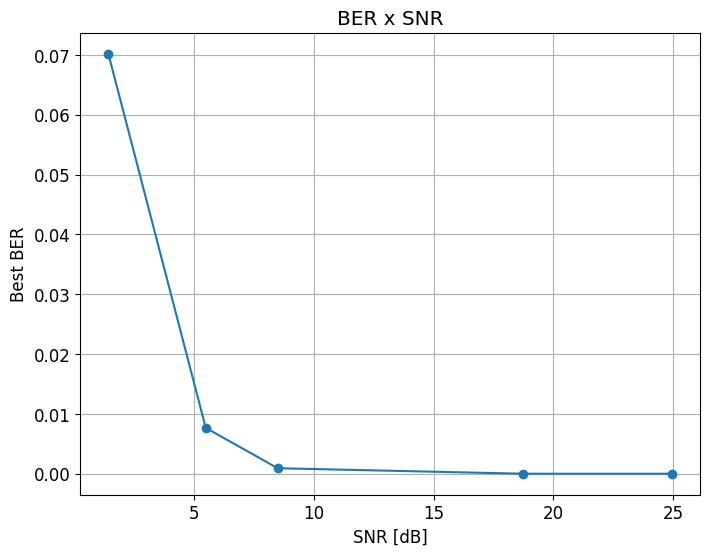

In [34]:
gBestPosHistory = np.zeros((pars,len(PSDArray)))
SNRArray = np.zeros(len(PSDArray))
saveminBER = np.ones(len(PSDArray)) 

progress = tqdm(total= gens*agents*len(PSDArray))

for p in range(len(PSDArray)):
    PNNPSO.output(NoisePSD=PSDArray[p])
    PNNPSO.update(inter)

    parArray = np.random.rand(pars,agents)*1.5*np.pi + 0.25*np.pi  # Position Array (parameters - phases)
    velArray = np.random.rand(pars,agents)/2  # Velocity Array (rate of change)
    pBest = np.zeros(agents)  # Personal best scores (Smaller BER)
    gBest = 0  # global best score (Smaller BER)
    pBestPos = np.zeros((pars,agents))  # Personal best positions
    gBestPos = np.zeros(pars)  # global best position reached

    # print(f'Initial Position Array: {parArray}')
    # print(f'Initial Velocity Array: {velArray}')

    currentEvals = np.zeros(agents)
    pathFollow = np.zeros((pars,agents,gens))
    pBestFollow = np.zeros((agents,gens))
    gBestFollow = np.zeros(gens)

    print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
    for i in range(gens):
        inertia = 0.9-(i/gens)*0.5

        for j in range(agents):
            # Simulation Section ---------------------------------------------------------
            inter.switchtolayout()
            inter.setnamed('IDEAL_CELL_5','Common Theta',parArray[0,j])
            inter.setnamed('IDEAL_CELL_6','Common Theta',parArray[1,j])
            inter.setnamed('IDEAL_CELL_7','Common Theta',parArray[2,j])
            inter.run()

            OSCData = inter.getresult('OSC_3','signal')
            Datakeys = list(OSCData.keys())
            OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.
            OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.

            LGCAData = inter.getresult('LGCA_4','digital signal')
            LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2],samplespBit) # in Interconnect, Each 2 samples are related to one bit

            corMax = np.argmax(np.correlate(LGCAbit,OSCPower))

            delayArray = np.floor(np.linspace(0,samplespBit-1,sampPositions)).astype(int)
            BERarray = np.zeros(sampPositions)
            minBERarray = np.zeros(len(ThreArray))
            minBERindex = np.zeros(len(ThreArray))

            for k in range(len(ThreArray)):
                Threshold = ThreArray[k]

                for m in range(sampPositions):
                    sampRef = LGCAbit[corMax+delayArray[m]:]
                    sampOut = OSCPower[delayArray[m]:]
                    sampRef = sampRef[::samplespBit]
                    sampOut = sampOut[::samplespBit]

                    transformed = [0 if x < Threshold else 1 for x in sampOut]
                    minIdx = min(len(transformed),len(sampRef))
                    errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
                    count = np.sum(errors==True)
                    if count/minIdx > 0.5:
                        BERarray[m] = 1 - count/minIdx
                    else: BERarray[m] = count/minIdx    

                minBERarray[k] = np.min(BERarray)
                minBERindex[k] = np.argmin(BERarray)

                if np.min(BERarray) < saveminBER[p]:  # Calculate the SNR on the lowest BER finded on this PSO setup
                    saveminBER[p] = np.min(BERarray)
                    sigPow = inter.getresultdata('Signal_Power','total power') # signal in dBm
                    noisePow = inter.getresultdata('Noise_Power','total power') # noise in dBm
                    SNRArray[p] = sigPow - noisePow

            progress.update(1)

            # PSO Section ---------------------------------------------------------
            currentEvals[j] = np.min(minBERarray)
            if currentEvals[j] < pBest[j] or i==0: 
                pBest[j] = currentEvals[j]
                pBestPos[:,j] = parArray[:,j]
            if np.min(currentEvals) < gBest or i==0:
                gBest = np.min(currentEvals)
                gBestPos = parArray[:,np.argmin(currentEvals)]

        tilgBest = np.transpose(np.tile(gBestPos,(agents,1)))

        # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

        velArray = inertia*velArray + 2*np.random.rand()/5*(pBestPos-parArray) + 2*np.random.rand()/5*(tilgBest - parArray)
        parArray = parArray + velArray

        pathFollow[:,:,i] = parArray
        pBestFollow[:,i] = pBest
        gBestFollow[i] = gBest

    plt.figure()
    plt.title(f'Score History (BER) | SNR of {np.round(SNRArray[p],2)}',fontsize=16, fontweight="bold")

    for i in range(agents):
        # if i%(int(agents/4))==0:
        plt.plot(np.arange(gens),pBestFollow[i,:],label=f'agent {i+1} pBest')
    plt.plot(np.arange(gens),gBestFollow,linestyle='--',label=f'gBest',color='gray')
    plt.xlabel('Generation')
    plt.ylabel('Score (BER)')
    plt.grid()
    plt.legend()

    datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
    file_count = sum(len(files) for _, _, files in os.walk(datapath))
    plt.savefig(datapath+"/"+"XOR_Particle_Swarm_B (SNR_" + str(np.round(SNRArray[p],2)) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")
    plt.close()


plt.figure()
plt.title('BER x SNR')
plt.xlabel('SNR [dB]')
plt.ylabel('Best BER')
plt.plot(SNRArray,saveminBER,'-o')
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"BERxSNR (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")

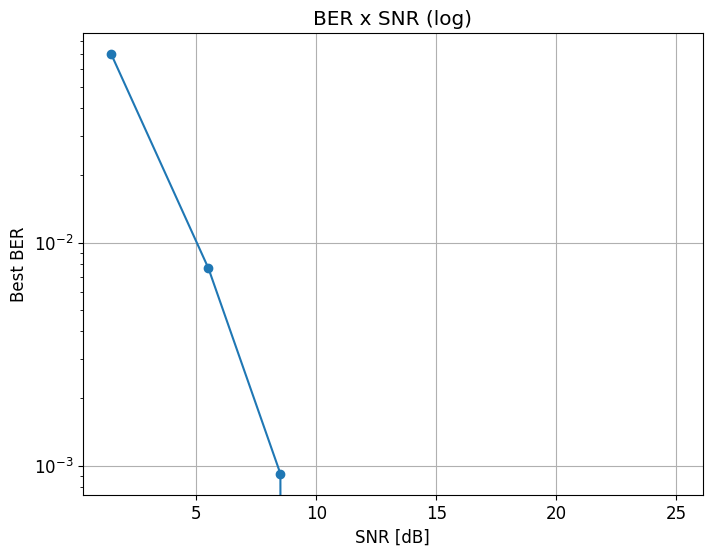

In [35]:
plt.figure()
plt.title('BER x SNR (log)')
plt.xlabel('SNR [dB]')
plt.ylabel('Best BER')
plt.plot(SNRArray,saveminBER,'-o')
plt.yscale('log')
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"BERxSNR (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")

### BER x SNR using Agent parallel simulation

In [100]:
samplespBit = 20  # Choosing Samples per bit
numberOfBits = 32767*1 # Choosing number of bits

# Choosing "Samples per Bit" and "Number of Bits" prior the "time window" and "number of samples" 
# avoid decimals and hence, avoid errors regarding different array sizes on simulations wiht large number of samples.

PNNPSO.simulation(numofSamples=samplespBit*numberOfBits)
timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*samplespBit)
PNNPSO.simulation(timeWindow=timeWindow)
PNNPSO.update(inter)

print(f'number of samples = {PNNPSO.getAttributes("numofSamples")[0]}')
print(f'samples per bit = {samplespBit}')
print(f'time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns')
print(f'bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

cutMargin = 8  # Signal cutting. This is valid for training purposes.
ThreArray = np.linspace(0.0001,0.0005,30)  # Threshold array.
sampPositions = samplespBit  # Number of sampling positions to assume. Must be lower than samples per bit.

agents = 4  # Number of agents
gens = 12  # Max number of gens per agent
pars = 3  # Number of parameters
PSDArray = np.logspace(-20,-18,5)  # Array of Noise PSD values
print(f'PSD Values: {PSDArray}')


# PSD Sweep object creation ----------------------------------------

inter.deletesweep('AgentSweep')
inter.addsweep(0)
inter.setsweep('sweep','name','AgentSweep')
inter.setsweep('AgentSweep','type','Values')
inter.setsweep('AgentSweep','number of points',agents)

ArmBParam = {'Name':'ArmB','Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number'}
ArmCParam = {'Name':'ArmC','Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number'}
ArmDParam = {'Name':'ArmD','Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number'}
for i in range(agents):
    param = 'Value_'+str(i+1)
    ArmBParam[param] = 0
    ArmCParam[param] = 0
    ArmDParam[param] = 0
inter.addsweepparameter('AgentSweep',ArmBParam)
inter.addsweepparameter('AgentSweep',ArmCParam)
inter.addsweepparameter('AgentSweep',ArmDParam)

OSC3Result = {'Name':'OSC3_Result','Result':'::Root Element::OSC_3::signal'}
SignalPower = {'Name':'Signal_Power','Result':'::Root Element::Signal_Power::total power'}
NoisePower = {'Name':'Noise_Power','Result':'::Root Element::Noise_Power::total power'}
DigitalSignal = {'Name':'Digital_Signal','Result':'::Root Element::LGCA_4::digital signal'}
inter.addsweepresult('AgentSweep',OSC3Result)
inter.addsweepresult('AgentSweep',SignalPower)
inter.addsweepresult('AgentSweep',NoisePower)
inter.addsweepresult('AgentSweep',DigitalSignal)

samples per bit = 20
bits = 26214.399999999998
PSD Values: [1.00000000e-20 3.16227766e-20 1.00000000e-19 3.16227766e-19
 1.00000000e-18]


'Digital_Signal'

  0%|          | 0/60 [00:00<?, ?it/s]

VelInit: 0.06315149622557026 | PosInit: 0.8464191877254215
VelInit: 0.03951686297796014 | PosInit: 2.4746427768319013
VelInit: 0.4575432581549256 | PosInit: 0.952924241066782
VelInit: 0.16680344249249018 | PosInit: 1.7641360057083209
VelInit: 0.14431919769332213 | PosInit: 3.709764452564309


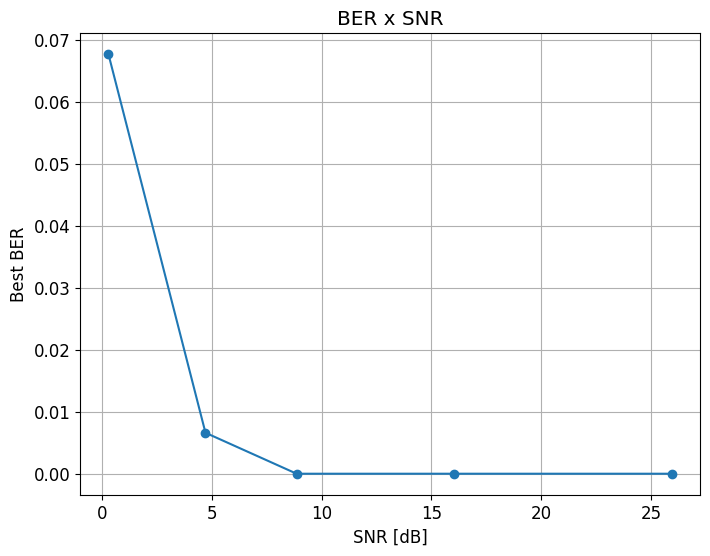

In [137]:
gBestPosHistory = np.zeros((pars,len(PSDArray)))
SNRArray = np.zeros(len(PSDArray))
saveminBER = np.ones(len(PSDArray)) 

progress = tqdm(total= gens*len(PSDArray))

for p in range(len(PSDArray)):
    PNNPSO.output(NoisePSD=PSDArray[p])
    PNNPSO.update(inter)

    parArray = np.random.rand(pars,agents)*1.5*np.pi + 0.25*np.pi  # Position Array (parameters - phases)
    velArray = np.random.rand(pars,agents)/2  # Velocity Array (rate of change)
    pBest = np.zeros(agents)  # Personal best scores (Smaller BER)
    gBest = 0  # global best score (Smaller BER)
    pBestPos = np.zeros((pars,agents))  # Personal best positions
    gBestPos = np.zeros(pars)  # global best position reached

    # print(f'Initial Position Array: {parArray}')
    # print(f'Initial Velocity Array: {velArray}')

    currentEvals = np.zeros(agents)
    pathFollow = np.zeros((pars,agents,gens))
    pBestFollow = np.zeros((agents,gens))
    gBestFollow = np.zeros(gens)

    # print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
    for i in range(gens):
        inertia = 0.9-(i/gens)*0.5

        # Simulation Section ---------------------------------------------------------
        inter.switchtolayout()
        for j in range(agents):
            param = 'Value_'+str(j+1)
            ArmBParam[param] = parArray[0,j]
            ArmCParam[param] = parArray[1,j]
            ArmDParam[param] = parArray[2,j]

        inter.setsweep('AgentSweep','ArmB',ArmBParam)
        inter.setsweep('AgentSweep','ArmC',ArmCParam)
        inter.setsweep('AgentSweep','ArmD',ArmDParam)
        inter.runsweep('AgentSweep')

        SweepOSC3 = inter.getsweepresult('AgentSweep','OSC3_Result')
        SweepSignal = inter.getsweepresult('AgentSweep','Signal_Power')
        SweepNoise = inter.getsweepresult('AgentSweep','Noise_Power')
        SweepDigital = inter.getsweepresult('AgentSweep','Digital_Signal')

        for j in range(agents):
            OSCTime = SweepOSC3['time'][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.
            OSCPower = SweepOSC3['amplitude (a.u.)'][cutMargin*samplespBit:-cutMargin*samplespBit,j] # Signal cutting. This is valid for training purposes.

            LGCAbit = np.repeat(SweepDigital['amplitude (a.u.)'][::2,j],samplespBit) # in Interconnect, Each 2 samples are related to one bit

            corMax = np.argmax(np.correlate(LGCAbit,OSCPower))

            delayArray = np.floor(np.linspace(0,samplespBit-1,sampPositions)).astype(int)
            BERarray = np.zeros(sampPositions)
            minBERarray = np.zeros(len(ThreArray))

            for k in range(len(ThreArray)):
                Threshold = ThreArray[k]

                for m in range(sampPositions):
                    sampRef = LGCAbit[corMax+delayArray[m]:]
                    sampOut = OSCPower[delayArray[m]:]
                    sampRef = sampRef[::samplespBit]
                    sampOut = sampOut[::samplespBit]

                    transformed = [0 if x < Threshold else 1 for x in sampOut]
                    minIdx = min(len(transformed),len(sampRef))
                    errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
                    count = np.sum(errors==True)
                    if count/minIdx > 0.5:
                        BERarray[m] = 1 - count/minIdx
                    else: BERarray[m] = count/minIdx    

                minBERarray[k] = np.min(BERarray)

                if np.min(BERarray) < saveminBER[p]:  # Calculate the SNR on the lowest BER finded on this PSO setup
                    saveminBER[p] = np.min(BERarray)
                    sigPow = float(SweepSignal['power (dBm)'][j]) # signal in dBm
                    noisePow = float(SweepNoise['power (dBm)'][j]) # noise in dBm
                    SNRArray[p] = sigPow - noisePow

            # PSO Section ---------------------------------------------------------
            currentEvals[j] = np.min(minBERarray)
            if currentEvals[j] < pBest[j] or i==0: 
                pBest[j] = currentEvals[j]
                pBestPos[:,j] = parArray[:,j]
            if np.min(currentEvals) < gBest or i==0:
                gBest = np.min(currentEvals)
                gBestPos = parArray[:,np.argmin(currentEvals)]
        
        progress.update(1)

        tilgBest = np.transpose(np.tile(gBestPos,(agents,1)))

        # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

        velArray = inertia*velArray + 2*np.random.rand()/5*(pBestPos-parArray) + 2*np.random.rand()/5*(tilgBest - parArray)
        parArray = parArray + velArray

        pathFollow[:,:,i] = parArray
        pBestFollow[:,i] = pBest
        gBestFollow[i] = gBest

    plt.figure()
    plt.title(f'Score History (BER) | SNR of {np.round(SNRArray[p],2)}',fontsize=16, fontweight="bold")

    for i in range(agents):
        # if i%(int(agents/4))==0:
        plt.plot(np.arange(gens),pBestFollow[i,:],label=f'agent {i+1} pBest')
    plt.plot(np.arange(gens),gBestFollow,linestyle='--',label=f'gBest',color='gray')
    plt.xlabel('Generation')
    plt.ylabel('Score (BER)')
    plt.grid()
    plt.legend()

    datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
    file_count = sum(len(files) for _, _, files in os.walk(datapath))
    plt.savefig(datapath+"/"+"XOR_Particle_Swarm_D (SNR_" + str(np.round(SNRArray[p],2)) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")
    plt.close()


plt.figure()
plt.title('BER x SNR')
plt.xlabel('SNR [dB]')
plt.ylabel('Best BER')
plt.plot(SNRArray,saveminBER,'-o')
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"BERxSNR (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")

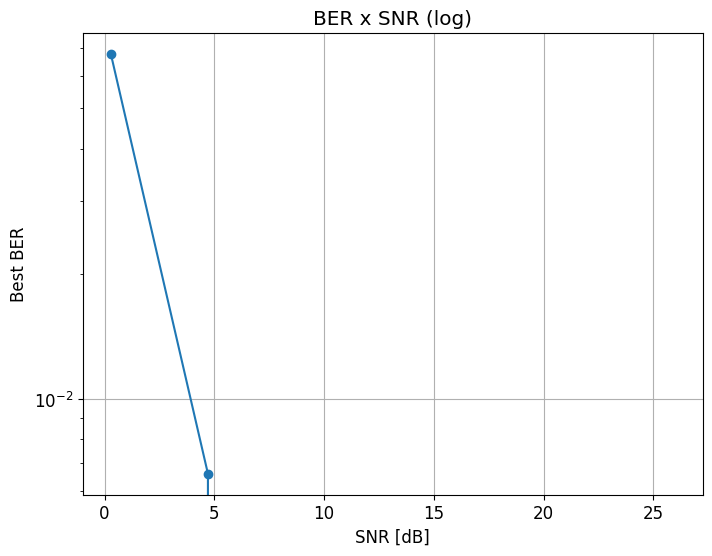

In [138]:
plt.figure()
plt.title('BER x SNR (log)')
plt.xlabel('SNR [dB]')
plt.ylabel('Best BER')
plt.plot(SNRArray,saveminBER,'-o')
plt.yscale('log')
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"BERxSNR (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")

### BER x SNR using PSD parallel simulation

In [24]:
samplespBit = 20  # Choosing Samples per bit
numberOfBits = 32767*1 # Choosing number of bits

# Choosing "Samples per Bit" and "Number of Bits" prior the "time window" and "number of samples" 
# avoid decimals and hence, avoid errors regarding different array sizes on simulations wiht large number of samples.

PNNPSO.simulation(numofSamples=samplespBit*numberOfBits)
timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*samplespBit)
PNNPSO.simulation(timeWindow=timeWindow)
PNNPSO.update(inter)

print(f'number of samples = {PNNPSO.getAttributes("numofSamples")[0]}')
print(f'samples per bit = {samplespBit}')
print(f'time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns')
print(f'bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

cutMargin = 8  # Signal cutting. This is valid for training purposes.
sampPositions = samplespBit  # Number of sampling positions to assume. Must be lower than samples per bit.

agents = 4  # Number of agents
gens = 12  # Max number of gens per agent
pars = 3  # Number of parameters
PSDArray = np.logspace(-19,-17.6,17)  # Array of Noise PSD values
print(f'PSD Values: {PSDArray}')


# PSD Sweep object creation ----------------------------------------

inter.deletesweep('PSDSweep')
inter.addsweep(0)
inter.setsweep('sweep','name','PSDSweep')
inter.setsweep('PSDSweep','type','Values')
inter.setsweep('PSDSweep','number of points',len(PSDArray))

ArmBParam = {'Name':'ArmB','Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number'}
ArmCParam = {'Name':'ArmC','Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number'}
ArmDParam = {'Name':'ArmD','Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number'}
AWGNParam = {'Name':'AWGN_PSD','Parameter':'::Root Element::AWGN_source::power spectral density',  'Type':'Number'}
for i in range(len(PSDArray)):
    param = 'Value_'+str(i+1)
    ArmBParam[param] = 0
    ArmCParam[param] = 0
    ArmDParam[param] = 0
    AWGNParam[param] = PSDArray[i]
inter.addsweepparameter('PSDSweep',ArmBParam)
inter.addsweepparameter('PSDSweep',ArmCParam)
inter.addsweepparameter('PSDSweep',ArmDParam)
inter.addsweepparameter('PSDSweep',AWGNParam)

OSC3Result = {'Name':'OSC3_Result','Result':'::Root Element::OSC_3::signal'}
SignalPower = {'Name':'Signal_Power','Result':'::Root Element::Signal_Power::total power'}
NoisePower = {'Name':'Noise_Power','Result':'::Root Element::Noise_Power::total power'}
DigitalSignal = {'Name':'Digital_Signal','Result':'::Root Element::LGCA_4::digital signal'}
inter.addsweepresult('PSDSweep',OSC3Result)
inter.addsweepresult('PSDSweep',SignalPower)
inter.addsweepresult('PSDSweep',NoisePower)
inter.addsweepresult('PSDSweep',DigitalSignal)

inter.setnamed('PRBS','output','PRBS')

number of samples = 655340
samples per bit = 20
time Window = 2047.9375 ns
bits = 32767.0
PSD Values: [1.00000000e-19 1.22320712e-19 1.49623566e-19 1.83020611e-19
 2.23872114e-19 2.73841963e-19 3.34965439e-19 4.09732110e-19
 5.01187234e-19 6.13055792e-19 7.49894209e-19 9.17275935e-19
 1.12201845e-18 1.37246096e-18 1.67880402e-18 2.05352503e-18
 2.51188643e-18]


run this cell to lock the binary sequence for all PSD points

In [237]:
inter.setnamed('PRBS','output','codeword')
codewordList = ''.join(map(str, np.random.randint(0, 2, size=(1000)).tolist())) # Creates 1000 random bits, converts to list, and creates a super string with all the elements
inter.setnamed('PRBS','codeword',codewordList)

No checkpoint loaded


  0%|          | 0/48 [00:00<?, ?it/s]

,SNR: 7.96,SNR: 10.53,SNR: 5.45,SNR: 6.08,SNR: 1.12,SNR: -0.22,SNR: -0.38
Arm B common mode (rad),-2.816327,4.476203,3.925187,1.723582,3.340956,2.788080,2.734091
Arm C common mode (rad),21.043642,9.300717,2.198820,3.970769,4.330226,3.110594,3.593619
Arm D common mode (rad),-16.914216,6.012765,1.235037,1.117882,5.332360,1.948684,7.881361


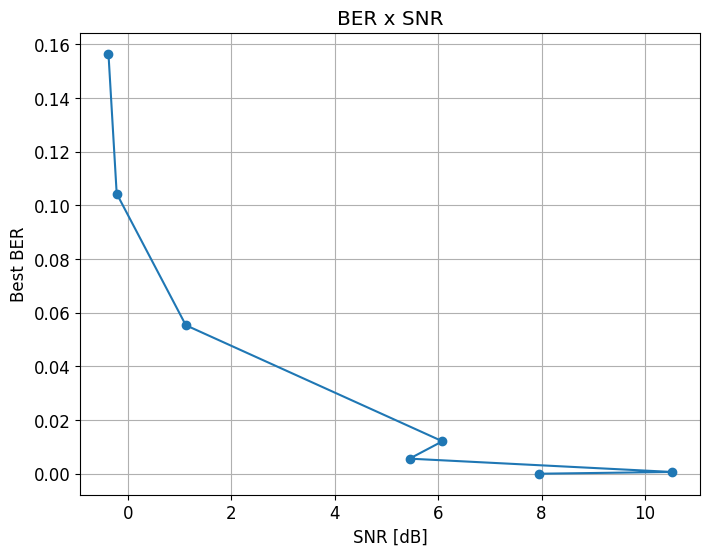

In [ ]:
LoadCheckpoint = 0  # ID for checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint != 0: print(f'Checkpoint {LoadCheckpoint} loaded')
else: print(f'No checkpoint loaded')

gBestPosHistory = np.zeros((pars,len(PSDArray)))
SNRArray = np.zeros(len(PSDArray))
PSDminBER = np.ones(len(PSDArray)) 

picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/PSDParallel/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

parArray = np.random.rand(pars,agents,len(PSDArray))*1.5*np.pi + 0.25*np.pi  # Position Array (parameters - phases)
velArray = np.random.rand(pars,agents,len(PSDArray))/2  # Velocity Array (rate of change)
pBest = np.zeros((agents,len(PSDArray)))  # Personal best scores (Smaller BER)
gBest = np.zeros(len(PSDArray))  # global best score (Smaller BER)
pBestPos = np.zeros((pars,agents,len(PSDArray)))  # Personal best positions
gBestPos = np.zeros((pars,len(PSDArray)))  # global best position reached

# print(f'Initial Position Array: {parArray}')
# print(f'Initial Velocity Array: {velArray}')

currentEvals = np.zeros((agents,len(PSDArray)))
pathFollow = np.zeros((pars,agents,gens,len(PSDArray)))
pBestFollow = np.zeros((agents,gens,len(PSDArray)))
gBestFollow = np.zeros((gens,len(PSDArray)))

lastgen = -1
if LoadCheckpoint != 0:
    with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','rb') as handle:
        LoadFile = pickle.load(handle)
    if LoadFile['LastGen']+1 >= gens:
        raise NameError(f'Last gen of this checkpoint is equal or superior the total number of gens (Last gen: {LoadFile["LastGen"]+1} | total: {gens}).')
    parArray = LoadFile['parArray']
    velArray = LoadFile['velArray']
    pathFollow = LoadFile['pathFollow']
    pBestFollow = LoadFile['pBestFollow']
    gBestFollow = LoadFile['gBestFollow']
    lastgen = LoadFile['LastGen']

progress = tqdm(total= (gens-lastgen-1)*agents)


# print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
for i in range(lastgen+1,gens):
    inertia = 0.9-(i/gens)*0.5

    for j in range(agents):
        # Simulation Section ---------------------------------------------------------
        inter.switchtolayout()
        for p in range(len(PSDArray)):
            param = 'Value_'+str(p+1)
            ArmBParam[param] = parArray[0,j,p]
            ArmCParam[param] = parArray[1,j,p]
            ArmDParam[param] = parArray[2,j,p]

        inter.setsweep('PSDSweep','ArmB',ArmBParam)
        inter.setsweep('PSDSweep','ArmC',ArmCParam)
        inter.setsweep('PSDSweep','ArmD',ArmDParam)
        inter.runsweep('PSDSweep')

        SweepOSC3 = inter.getsweepresult('PSDSweep','OSC3_Result')
        SweepSignal = inter.getsweepresult('PSDSweep','Signal_Power')
        SweepNoise = inter.getsweepresult('PSDSweep','Noise_Power')
        SweepDigital = inter.getsweepresult('PSDSweep','Digital_Signal')

        for p in range(len(PSDArray)):
            # OSCTime = SweepOSC3['time'][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.
            OSCPower = SweepOSC3['amplitude (a.u.)'][cutMargin*samplespBit:-cutMargin*samplespBit,p] # Signal cutting. This is valid for training purposes.

            ThreArray = np.linspace(np.max(OSCPower),(np.min(OSCPower)>0)*np.min(OSCPower),60)  # Threshold array.

            LGCAbit = np.repeat(SweepDigital['amplitude (a.u.)'][::2,p],samplespBit) # in Interconnect, Each 2 samples are related to one bit. Expanding the binary sequence

            # Correlation at "valid mode", the result length will be given by:
            # Maxlen(LGCAbit,OSCPower) -  Minlen(LGCAbit,OSCPower) + 1. Which is sufficient
            corMax = np.argmax(np.correlate(LGCAbit,OSCPower))

            delayArray = np.floor(np.linspace(0,samplespBit-1,sampPositions)).astype(int)
            BERarray = np.zeros(sampPositions)
            minBERarray = np.zeros(len(ThreArray))

            for k in range(len(ThreArray)):
                Threshold = ThreArray[k]

                for m in range(sampPositions):
                    sampRef = LGCAbit[corMax+delayArray[m]:]   # Expanded binary sequence with correlationMax delay + Sampling position delay
                    sampOut = OSCPower[delayArray[m]:]
                    sampRef = sampRef[::samplespBit]  # Unexpanding back the binary sequence
                    sampOut = sampOut[::samplespBit]

                    transformed = [0 if x < Threshold else 1 for x in sampOut]
                    minIdx = min(len(transformed),len(sampRef))
                    errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
                    count = np.sum(errors==True)
                    if count/minIdx > 0.5:
                        BERarray[m] = 1 - count/minIdx
                    else: BERarray[m] = count/minIdx    

                minBERarray[k] = np.min(BERarray)

                if np.min(BERarray) < PSDminBER[p]:  # Initial value of PSDminBER starts at 1
                    PSDminBER[p] = np.min(BERarray)  # Save the lowest BER, for this PSD point, of all the agents and generations 
                    sigPow = float(SweepSignal['power (dBm)'][p]) # signal in dBm
                    noisePow = float(SweepNoise['power (dBm)'][p]) # noise in dBm
                    SNRArray[p] = sigPow - noisePow  # Calculate the SNR on the lowest BER finded on this PSO setup
            

            # PSO Section ---------------------------------------------------------
            currentEvals[j,p] = np.min(minBERarray)
            if currentEvals[j,p] < pBest[j,p] or i==0: 
                pBest[j,p] = currentEvals[j,p]
                pBestPos[:,j,p] = parArray[:,j,p]
            if np.min(currentEvals[:,p]) < gBest[p] or i==0:
                gBest[p] = np.min(currentEvals[:,p])
                gBestPos[:,p] = parArray[:,np.argmin(currentEvals[:,p]),p]

        
        progress.update(1)


    # Preparations before the next generation (Saving and PSO velocities calculation)

    for p in range(len(PSDArray)):
        tilgBest = np.transpose(np.tile(gBestPos[:,p],(agents,1)))

        # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

        velArray[:,:,p] = inertia*velArray[:,:,p] + 2*np.random.rand()/5*(pBestPos[:,:,p]-parArray[:,:,p]) + 2*np.random.rand()/5*(tilgBest - parArray[:,:,p])
        parArray = parArray + velArray

        pathFollow[:,:,i,p] = parArray[:,:,p]
        pBestFollow[:,i,p] = pBest[:,p]
        gBestFollow[i,p] = gBest[p]

    SaveFile['LastGen'] = i
    SaveFile['velArray'] = velArray
    SaveFile['parArray'] = parArray
    SaveFile['pathFollow'] = pathFollow
    SaveFile['pBestFollow'] = pBestFollow
    SaveFile['gBestFollow'] = pBestFollow
    if LoadCheckpoint == 0:
        with open(picklepath+'Checkpoint('+str(checkpoint_count+1)+').pickle','wb') as handle:
            pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','wb') as handle:
            pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)

for p in range(len(PSDArray)):
    plt.figure()
    plt.title(f'Score History (BER) | SNR of {np.round(SNRArray[p],2)}',fontsize=16, fontweight="bold")

    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True

    for i in range(agents):
        plt.plot(np.arange(gens),pBestFollow[i,:,p],label=f'agent {i+1} pBest')
    plt.plot(np.arange(gens),gBestFollow[:,p],linestyle='--',label=f'gBest',color='gray')
    plt.xlabel('Generation')
    plt.ylabel('Score (BER)')
    plt.grid()
    plt.legend()

    datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm/PSDParallel'
    file_count = sum(len(files) for _, _, files in os.walk(datapath))
    plt.savefig(datapath+"/"+"XOR_Particle_Swarm (SNR point " + str(p+1) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")
    plt.close()


plt.figure()
plt.title('BER x SNR')
plt.xlabel('SNR [dB]')
plt.ylabel('Best BER')
plt.plot(SNRArray,PSDminBER,'-o')
plt.grid()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm/PSDParallel'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"BERxSNR (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")


# Dataframe plot -------------------------------------------

SNRstrings = list(np.zeros(len(SNRArray)))
for p in range(len(SNRArray)):
    SNRstrings[p] = "SNR: " + str(np.round(SNRArray[p],2))

dataFrame = DataFrame(gBestPos,
                    columns=SNRstrings,
                    index=['Arm B common mode (rad)','Arm C common mode (rad)','Arm D common mode (rad)'])
dataFrame

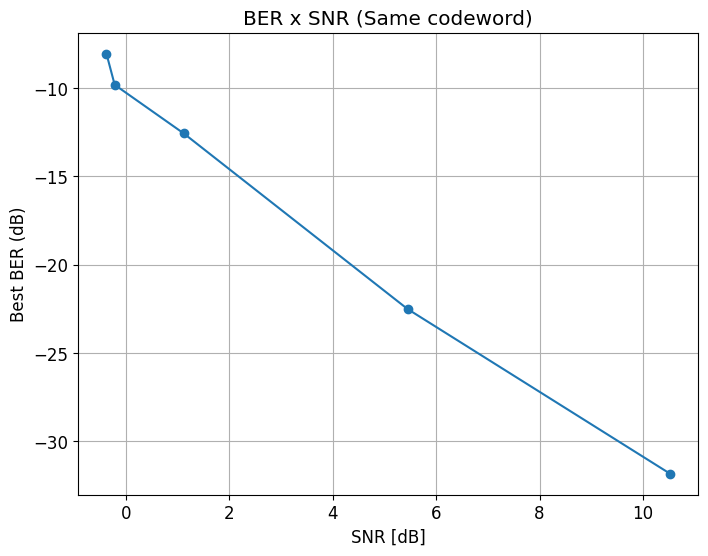

In [252]:
plt.figure()
plt.title('BER x SNR (Same codeword)')
plt.xlabel('SNR [dB]')
plt.ylabel('Best BER (dB)')
plt.plot(SNRArray,10*np.log10(PSDminBER),'-o')
plt.grid()

# datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm/PSDParallel'
# file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"BERxSNR (" + str(file_count) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")

### Training using Agent Parallel simulation

In [141]:
samplespBit = 32*2 # Choosing Samples per bit
numberOfBits = 32768*1 # Choosing number of bits
# numberOfBits = 1048*2 # Choosing number of bits

# Choosing "Samples per Bit" and "Number of Bits" prior the "time window" and "number of samples" 
# avoid de'cimals and hence, avoid errors regarding different array sizes on simulations wiht large number of samples.

# PNNPSO.output(NoisePSD=1e-20)
# PNNPSO.output(NoisePSD=1e-20)
PNNPSO.simulation(bitrate=16e9,numofSamples=samplespBit*numberOfBits)
timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*samplespBit)
PNNPSO.simulation(timeWindow=timeWindow)
PNNPSO.update(inter)

print(f'number of samples = {PNNPSO.getAttributes("numofSamples")[0]}')
print(f'samples per bit = {samplespBit}')
print(f'time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns')
print(f'bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

cutMargin = 8  # Signal cutting. This is valid for training purposes.

agents = 4  # Number of agents
gens = 8  # Max number of gens per agent
pars = 3  # Number of parameters

mydir = "../../../simulation/files/pnn/"
myfolder = 'AnalysisPNN_AgentSweep'

# PSD Sweep object creation ----------------------------------------

def recreateAgentSweep(inter,agents,mydir,myfolder):

    path = os.path.join(mydir, myfolder)

    # If directory exists, delete it.
    if os.path.isdir(mydir+myfolder): shutil.rmtree(path, ignore_errors=False)
    else: print("%s directory not found" % {mydir+myfolder})

    inter.deletesweep('AgentSweep')
    inter.addsweep(0)
    inter.setsweep('sweep','name','AgentSweep')
    inter.setsweep('AgentSweep','type','Values')
    inter.setsweep('AgentSweep','number of points',agents)

    ArmBParam = {'Name':'ArmB','Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number'}
    ArmCParam = {'Name':'ArmC','Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number'}
    ArmDParam = {'Name':'ArmD','Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number'}
    for i in range(agents):
        param = 'Value_'+str(i+1)
        ArmBParam[param] = 0
        ArmCParam[param] = 0
        ArmDParam[param] = 0
    inter.addsweepparameter('AgentSweep',ArmBParam)
    inter.addsweepparameter('AgentSweep',ArmCParam)
    inter.addsweepparameter('AgentSweep',ArmDParam)

    OSC3Result = {'Name':'OSC3_Result','Result':'::Root Element::OSC_2::signal'}
    # SignalPower = {'Name':'Signal_Power','Result':'::Root Element::Signal_Power::total power'}
    # NoisePower = {'Name':'Noise_Power','Result':'::Root Element::Noise_Power::total power'}
    DigitalSignal = {'Name':'Digital_Signal','Result':'::Root Element::LGCA_4::digital signal'}
    inter.addsweepresult('AgentSweep',OSC3Result)
    # inter.addsweepresult('AgentSweep',SignalPower)
    # inter.addsweepresult('AgentSweep',NoisePower)
    inter.addsweepresult('AgentSweep',DigitalSignal)

number of samples = 2097152
samples per bit = 64
time Window = 2048.0 ns
bits = 32768.0


In [142]:
LoadCheckpoint = 0  # ID for checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint != 0: print(f'Checkpoint {LoadCheckpoint} loaded')
else: print(f'No checkpoint loaded')

PSDminBER = 1
OptSampPos = 1
OptThreshold = 0
SNRValue = 0

picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Training/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

parArray = np.random.rand(pars,agents)*1.5*np.pi + 0.25*np.pi  # Position Array (parameters - phases)
velArray = np.random.rand(pars,agents)/2  # Velocity Array (rate of change)
pBest = 0.5*np.ones(agents)  # Personal best score for each agent (Smallest BER)
gBest = 0.5  # Global best score (Smallest BER)
pBestPos = np.zeros((pars,agents))  # Personal best (pBest) associated positions
gBestPos = np.zeros(pars)  # Global best (gBest) associated position

pathFollow = np.zeros((pars,agents,gens))
pBestFollow = np.zeros((agents,gens))
gBestFollow = np.zeros(gens)
ThreFollow = np.zeros((agents,gens))
SampFollow = np.zeros((agents,gens))

lastgen = -1
stopGen = gens

def PSO_training(): 
    global lastgen, parArray, velArray, pathFollow, pBestFollow, gBestFollow, pBestPos, gBestPos, OptThreshold, OptSampPos, PSDminBER, pBest, gBest
    global PSDminBER, OptSampPos, OptThreshold, SNRValue, stopGen, LoadCheckpoint, ThreFollow, SampFollow

    if LoadCheckpoint != 0:
        with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','rb') as handle:
            LoadFile = pickle.load(handle)
        # if LoadFile['LastGen']+1 >= gens:
            # raise NameError(f'Last gen of this checkpoint is equal or superior the total number of gens (Last gen: {LoadFile["LastGen"]+1} | total: {gens}).')
        lastgen = LoadFile['LastGen']
        parArray = LoadFile['parArray']
        velArray = LoadFile['velArray']
        pathFollow = LoadFile['pathFollow']
        pBestFollow = LoadFile['pBestFollow']
        gBestFollow = LoadFile['gBestFollow']
        gBestPos = LoadFile['gBestPos']
        OptThreshold = LoadFile['OptThreshold']
        OptSampPos = LoadFile['OptSampPos']
        PSDminBER = LoadFile['PSDminBER']
        ThreFollow = LoadFile['ThreFollow']
        SampFollow = LoadFile['SampFollow']
        pBest = pBestFollow[:,int(lastgen)].copy()
        gBest = gBestFollow[int(lastgen)].copy()
        # print(f'Loaded pBest: {pBest}')
        # print(f'Loaded pBest follow agent 1: {pBestFollow[0,:]}')
        # print(f'lastgen: {lastgen}')

    progress = tqdm(total= (gens-lastgen-1))

    # print(f'VelInit: {velArray[0,0]} | PosInit: {parArray[0,0]}')
    
    for i in range(lastgen+1,gens):
        print(f'starting with gbest: {gBest}')

        if (np.all(pBestFollow[:,int(i-1)] < 1/numberOfBits)) and i > 0:  # Stop the simulation if all the agents have already converged to BER = zero
            stopGen = i-1
            break
        
        inertia = 0.9-(i/gens)*0.5

        # Simulation Section ---------------------------------------------------------
        inter.switchtolayout()
        recreateAgentSweep(inter,agents,mydir,myfolder)

        ArmBParam = {'Name':'ArmB','Parameter':'::Root Element::IDEAL_CELL_5::Common Theta',  'Type':'Number'}
        ArmCParam = {'Name':'ArmC','Parameter':'::Root Element::IDEAL_CELL_6::Common Theta',  'Type':'Number'}
        ArmDParam = {'Name':'ArmD','Parameter':'::Root Element::IDEAL_CELL_7::Common Theta',  'Type':'Number'}
        for j in range(agents):
            param = 'Value_'+str(j+1)
            ArmBParam[param] = parArray[0,j]
            ArmCParam[param] = parArray[1,j]
            ArmDParam[param] = parArray[2,j]
        
        inter.setsweep('AgentSweep','ArmB',ArmBParam)
        inter.setsweep('AgentSweep','ArmC',ArmCParam)
        inter.setsweep('AgentSweep','ArmD',ArmDParam)
        inter.runsweep('AgentSweep')

        try: 

            SweepOSC3 = inter.getsweepresult('AgentSweep','OSC3_Result')
            # SweepSignal = inter.getsweepresult('AgentSweep','Signal_Power')
            # SweepNoise = inter.getsweepresult('AgentSweep','Noise_Power')
            SweepDigital = inter.getsweepresult('AgentSweep','Digital_Signal')

            AgentminBER = np.zeros(agents)  # Array of each agent's minimum BER for this generation

            for j in range(agents):

                OSCPower = SweepOSC3['amplitude (a.u.)'][int(cutMargin*samplespBit) : int(-cutMargin*samplespBit) , j] # Signal cutting. This is valid for training purposes.

                LGCAbit = np.repeat(SweepDigital['amplitude (a.u.)'][::2,j],samplespBit) # in Interconnect, Each 2 samples are related to one bit.

                ThreArray = np.linspace(np.max(OSCPower),(np.min(OSCPower)>0)*np.min(OSCPower),200)  # Threshold array.

                delayArray = np.floor(np.linspace(0,samplespBit-1,samplespBit)).astype(int)  # Sampling position array. Number of sampling positions must be lower than samples per bit.


                # Correlation at "full" mode, the result length will be given by:
                # len(LGCAbit) + len(OSCPower)
                corMax = np.argmax(np.correlate(OSCPower,LGCAbit,mode='full'))

                # if(corMax > len(LGCAbit)): print(f'LGCA signal cutted (corMax:{corMax} > LGCAbit:{len(LGCAbit)}')
                # else: print(f'Normal (corMax:{corMax} < LGCAbit:{len(LGCAbit)}')

                SampBERarray = np.zeros(samplespBit)  # BER array of each sampling position
                ThreBERarray = np.zeros(len(ThreArray))  # Minimum reached BER array of each threshold value
                SampOptIdx = np.zeros(len(ThreArray)) # Best sampling position for each threshold value

                for k in range(len(ThreArray)):
                    Threshold = ThreArray[k]

                    for m in range(samplespBit):
                        if(corMax < len(LGCAbit)):   # If LGCA signal needs to be cutted
                            sampRef = LGCAbit[int(len(LGCAbit)-corMax+delayArray[m]):]
                            sampOut = OSCPower[delayArray[m]:]
                        else:                        # If OSC power signal needs to be cutted
                            sampRef = LGCAbit[delayArray[m]:]
                            sampOut = OSCPower[int(corMax-len(LGCAbit)+delayArray[m]):]
                        # print(f'SampRef:{len(sampRef)} | SampOut:{len(sampOut)}')
                        sampRef = sampRef[::samplespBit]
                        sampOut = sampOut[::samplespBit]

                        transformed = (sampOut >= Threshold).astype(int)
                        minIdx = min(len(transformed),len(sampRef))
                        errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
                        count = np.sum(errors)
                        SampBERarray[m] = 0.5 - abs(0.5 - count / minIdx)

                    ThreBERarray[k] = np.min(SampBERarray)  # Minimum reached BER of all sampling positions in this threshold value
                    SampOptIdx[k] = np.argmin(SampBERarray)+1  # Best sampling position for this threshold value k

                    if ThreBERarray[k] < PSDminBER:  # Save the lowest BER finded on this PSO setup (saved between generations)
                        PSDminBER = ThreBERarray[k]
                        OptSampPos = np.argmin(SampBERarray)+1   # Sampling position of the optimum BER value in this PSO setup (saved between generations)
                        OptThreshold = ThreArray[k]  # Threshold value of the optimum BER value in this PSO setup (saved between generations)
                        # sigPow = float(SweepSignal['power (dBm)'][j]) # signal in dBm
                        # noisePow = float(SweepNoise['power (dBm)'][j]) # noise in dBm
                        # SNRValue = sigPow - noisePow    # Calculate the SNR on the lowest BER finded on this PSO setup (saved between generations)

                # PSO Section ---------------------------------------------------------
                AgentminBER[j] = np.min(ThreBERarray)   # Minimum reached BER of all threshold values (minimum BER reached by this agent in this generation)
                ThreFollow[j,i] = ThreArray[int(np.argmin(ThreBERarray))]   # Best threshold value for this agent and generation
                SampFollow[j,i] = SampOptIdx[int(np.argmin(ThreBERarray))]  # Best sampling position for the best threshold value for this agent and generation

                if AgentminBER[j] < pBest[j]:  # If this agent reached a new personal best, update it and its associated positions
                    pBest[j] = AgentminBER[j]
                    pBestPos[:,j] = parArray[:,j]
                    if pBest[j] < gBest:  # If this agent reached a new global best, update it and its associated positions
                        gBest = pBest[j]
                        gBestPos = pBestPos[:,j]

            # print(f'Addition to pBest follow agent 1: {pBest}')

            pathFollow[:,:,i] = parArray
            pBestFollow[:,i] = pBest
            gBestFollow[i] = gBest

            # print(f'After pBest follow agent 1: {pBestFollow[0,:]}')

            # Paramater step section for the next generation ------------------------------

            tilgBest = np.transpose(np.tile(gBestPos,(agents,1)))

            # print(f'velArray: {velArray[0,0]} | pbest-par: {pBestPos[0,0]-parArray[0,0]} | gBest-par: {tilgBest[0,0] - parArray[0,0]} || (pbest: {pBestPos[0,0]} and gbest: {tilgBest[0,0]})')

            velArray = inertia*velArray + 2*np.random.rand()/5*(pBestPos-parArray) + 2*np.random.rand()/5*(tilgBest - parArray)
            parArray = parArray + velArray

            progress.update(1)

            SaveFile['LastGen'] = i
            SaveFile['velArray'] = velArray
            SaveFile['parArray'] = parArray
            SaveFile['pathFollow'] = pathFollow
            SaveFile['pBestFollow'] = pBestFollow
            SaveFile['gBestFollow'] = gBestFollow
            SaveFile['gBestPos'] = gBestPos
            SaveFile['OptThreshold'] = OptThreshold
            SaveFile['OptSampPos'] = OptSampPos
            SaveFile['PSDminBER'] = PSDminBER
            SaveFile['ThreFollow'] = ThreFollow
            SaveFile['SampFollow'] = SampFollow
            if LoadCheckpoint == 0:
                with open(picklepath+'Checkpoint('+str(checkpoint_count+1)+').pickle','wb') as handle:
                    pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)
            else:
                with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','wb') as handle:
                    pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)

        except Exception as e:
            import traceback

            if isinstance(e, LumApiError):
                if "has no results" in str(e) and "'AgentSweep'" in str(e):
                    print("🛑 Known Error Detected: No results in AgentSweep. Retrying.")
                    return {"status":"retry"}
                
            if isinstance(e, KeyError):
                if "'amplitude (a.u.)'" in str(e) or "amplitude (a.u.)" in str(e):
                    print("🛑 Known Error Detected:: KeyError 'amplitude (a.u.)' not present.")
                    return {"status":"retry"}
                
            raise
        
        print(pBestFollow[:,i])

    # return {"status":"ok", "SNRValue":SNRValue, 
    #         "pBestFollow":pBestFollow, "gBestFollow":gBestFollow, "pathFollow":pathFollow,
    #         "stopGen":stopGen,
    #         "gBestPos":gBestPos, "OptThreshold":OptThreshold, "OptSampPos":OptSampPos}
    return {"status":"ok",
            "pBestFollow":pBestFollow, "gBestFollow":gBestFollow, "pathFollow":pathFollow,
            "stopGen":stopGen, "ThreFollow":ThreFollow, "SampFollow":SampFollow,
            "gBestPos":gBestPos, "OptThreshold":OptThreshold, "OptSampPos":OptSampPos}

attempts = 0
while attempts <= gens:
    attempts += 1

    PSOOut = PSO_training()

    if PSOOut["status"] == "retry" and LoadCheckpoint != 0:
        print(f"⚠️ Retrying... Attempt {attempts}")
    elif PSOOut["status"] == "ok":
        break
    elif LoadCheckpoint == 0:
        if sum(len(files) for _, _, files in os.walk(picklepath)) == checkpoint_count:
            raise Exception("❗️Cannot retry if no checkpoint exists for this simulation")
        LoadCheckpoint = checkpoint_count+1
        print(f'🔃 Load Checkpoint altered to {LoadCheckpoint}')
        print(f"⚠️ Retrying... Attempt {attempts}")

if attempts > gens:
    raise Exception(f"❌ Maximum attempts reached ({gens}).")

# Training Score History Plot ------------------------------

# SNRValue = PSOOut["SNRValue"]
pBestFollow = PSOOut["pBestFollow"]
gBestFollow = PSOOut["gBestFollow"]
pathFollow = PSOOut["pathFollow"]
stopGen = PSOOut["stopGen"]
ThreFollow = PSOOut["ThreFollow"]
SampFollow = PSOOut["SampFollow"]

plt.figure()
# plt.title(f'Score History (BER) | SNR of {np.round(SNRValue,2)} dB',fontsize=16, fontweight="bold")
plt.title(f'Score History (BER)',fontsize=16, fontweight="bold")

plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True

for i in range(agents):
    plt.plot(np.arange(1,gens+1),pBestFollow[i,:],label=f'agent {i+1} pBest')
plt.plot(np.arange(1,gens+1),gBestFollow,linestyle='--',label=f'gBest',color='gray')
plt.xlabel('Generation')
plt.ylabel('Score (BER)')
plt.yscale('log')

plt.grid()
plt.legend()

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm/16Gbps_Multiples/Training_Score_History'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"XOR_Particle_Swarm ("+str(file_count)+") (SNR_" + str(np.round(SNRValue,2)) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")
plt.savefig(datapath+"/"+"XOR_Particle_Swarm ("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
plt.close()



# Position History Plot ------------------------------------

figure,ax=plt.subplots(int(agents/2), 2,figsize=( 18, int(5*agents/2) ))
# figure.suptitle(f'Training: Position History | SNR of {np.round(SNRValue,2)} dB',fontsize=16, fontweight="bold")
figure.suptitle(f'Training: Position History',fontsize=16, fontweight="bold")
figure.tight_layout()

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.92      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for i in range(agents):
    idx1 = int(i%2)
    idx2 = int(i/2)
    ax[idx1][idx2].plot(np.arange(1,gens+1),pathFollow[0,i,:], label='ArmB')
    ax[idx1][idx2].plot(np.arange(1,gens+1),pathFollow[1,i,:], label='ArmC')
    ax[idx1][idx2].plot(np.arange(1,gens+1),pathFollow[2,i,:], label='ArmD')
    ax[idx1][idx2].vlines(x=int(np.where(gBestFollow == gBest)[0][0] + 1), ymin=np.min(pathFollow), ymax=np.max(pathFollow), label='gBest reached', color='gray', linestyle='--', alpha=0.8, linewidth=2)
    if np.size(np.where(pBestFollow[i,:] == gBest)) != 0:
        ax[idx1][idx2].vlines(x=int(np.where(pBestFollow[i,:] == gBest)[0][0] + 1), ymin=np.min(pathFollow), ymax=np.max(pathFollow), label='pBest = gBest', color='purple', linestyle='-.', alpha=0.4, linewidth=2)
    ax[idx1][idx2].set_xlabel('Generations',fontsize=10)
    ax[idx1][idx2].set_ylabel('common mode phase (rad)',fontsize=10)
    ax[idx1][idx2].set_title(f'Agent {i+1}')
    ax[idx1][idx2].set_ylim(np.min(pathFollow),np.max(pathFollow))
    ax[idx1][idx2].set_xlim(1,stopGen)
    ax[idx1][idx2].grid()
    ax[idx1][idx2].legend(fontsize=10)

datapath = '../../../data/Media/PNN_Results/ParallelModel/ParticleSwarm/16Gbps_Multiples/Position_History'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
# plt.savefig(datapath+"/"+"PositionHistory ("+str(file_count)+") (SNR_" + str(np.round(SNRValue,2)) + ") .png", transparent=False, facecolor="white", bbox_inches="tight")
plt.savefig(datapath+"/"+"PositionHistory ("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
plt.close()



# Dataframe plot -------------------------------------------

# SNRstring = np.array(["SNR: " + str(np.round(SNRValue,2))])
SNRstring = np.array(["First Zero: SNR: " + str(np.round(0,2))])
dataInfo = np.zeros(len(PSOOut["gBestPos"])+2)
dataInfo[0:3] = PSOOut["gBestPos"]
dataInfo[3] = PSOOut["OptThreshold"]
dataInfo[4] = PSOOut["OptSampPos"]

dataFrame = DataFrame(dataInfo,
                    columns=SNRstring,
                    index=['Arm B common mode (rad)','Arm C common mode (rad)','Arm D common mode (rad)','Optimal Threshold','Optimal sample position'])
dataFrame

No checkpoint loaded


  0%|          | 0/8 [00:00<?, ?it/s]

starting with gbest: 0.5
[0.22426111 0.35307767 0.31245802 0.12545799]
starting with gbest: 0.12545798729848556
[0.21461285 0.21525403 0.31245802 0.05877504]
starting with gbest: 0.05877503663898387
[0.19565217 0.         0.31245802 0.04482169]
starting with gbest: 0.0
🛑 Known Error Detected: No results in AgentSweep. Retrying.
🔃 Load Checkpoint altered to 5
⚠️ Retrying... Attempt 1


  0%|          | 0/5 [00:00<?, ?it/s]

starting with gbest: 0.0
[0.01886908 0.         0.14912066 0.        ]
starting with gbest: 0.0
[0.01886908 0.         0.         0.        ]
starting with gbest: 0.0
[0.00274792 0.         0.         0.        ]
starting with gbest: 0.0
[6.10649731e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
starting with gbest: 0.0
[0. 0. 0. 0.]


,First Zero: SNR: 0
Arm B common mode (rad),2.927108
Arm C common mode (rad),4.263217
Arm D common mode (rad),4.958472
Optimal Threshold,0.000048
Optimal sample position,28.000000


In [143]:
Genstring = np.zeros(len(pathFollow[0,0,:]), dtype='U10')
for i in range(len(pathFollow[0,0,:])): Genstring[i] = "Gen: " + str(i+1)
Indexstring = np.zeros(int(len(pathFollow[:,0,0])*len(pathFollow[0,:,0])), dtype='U10')
dataInfo = np.zeros((int(len(pathFollow[:,0,0])*len(pathFollow[0,:,0])) , len(pathFollow[0,0,:])))
for i in range(len(pathFollow[0,:,0])): 
    Indexstring[int(len(pathFollow[:,0,0])*i)] = "Arm B (" + str(i+1) +"): "
    Indexstring[int(len(pathFollow[:,0,0])*i + 1)] = "Arm C (" + str(i+1) +"): "
    Indexstring[int(len(pathFollow[:,0,0])*i + 2)] = "Arm D (" + str(i+1) +"): "
    dataInfo[int(len(pathFollow[:,0,0])*i):int(len(pathFollow[:,0,0])*i)+3,:] = np.round(pathFollow[:,i,:],6)

dataFrame2 = DataFrame(dataInfo,
                    columns=Genstring,
                    index=Indexstring)
dataFrame2

,Gen: 1,Gen: 2,Gen: 3,Gen: 4,Gen: 5,Gen: 6,Gen: 7,Gen: 8
Arm B (1):,5.195398,4.922124,4.618418,3.854371,3.186554,2.727269,2.531401,2.586292
Arm C (1):,2.600069,2.889080,3.081276,3.599682,4.057374,4.380084,4.526423,4.498341
Arm D (1):,4.354653,4.658207,4.874095,5.067783,5.191234,5.196651,5.111681,5.006006
Arm B (2):,1.674334,2.321785,2.927108,3.396233,3.503680,3.368601,3.048469,2.820194
Arm C (2):,5.308917,4.822775,4.263217,3.829559,3.730236,3.855102,4.151031,4.362047
Arm D (2):,4.780679,4.905439,4.958472,4.999573,5.008987,4.997152,4.969105,4.949105
Arm B (3):,4.702754,4.816909,4.831056,4.198118,3.577959,2.990568,2.724930,2.749225
Arm C (3):,3.548007,3.602999,3.555461,3.737019,3.936424,4.158568,4.288877,4.312698
Arm D (3):,3.310989,3.366161,3.436662,3.919232,4.401402,4.872546,5.098576,5.093425
Arm B (4):,3.151277,3.511138,3.812522,3.769329,3.626441,3.345874,3.100264,2.967535


In [144]:
Genstring = np.zeros(len(pathFollow[0,0,:]), dtype='U10')
for i in range(len(pathFollow[0,0,:])): Genstring[i] = "Gen: " + str(i+1)
Indexstring = np.zeros(int(2*len(pathFollow[0,:,0])), dtype='U10')
dataInfo = np.zeros((int(2*len(pathFollow[0,:,0])) , len(pathFollow[0,0,:])))
for i in range(len(pathFollow[0,:,0])): 
    Indexstring[i] = "Thre (" + str(i+1) +"):"
    Indexstring[int(i+len(pathFollow[0,:,0]))] = "SampPos (" + str(i+1) +"):"
    dataInfo[:len(pathFollow[0,:,0]),:] = ThreFollow[:,:]
    dataInfo[len(pathFollow[0,:,0]):2*len(pathFollow[0,:,0]),:] = SampFollow[:,:]

dataFrame3 = DataFrame(dataInfo,
                    columns=Genstring,
                    index=Indexstring)
dataFrame3

,Gen: 1,Gen: 2,Gen: 3,Gen: 4,Gen: 5,Gen: 6,Gen: 7,Gen: 8
Thre (1):,0.000066,0.000052,0.000067,0.000068,0.000036,0.000036,0.000042,0.000047
Thre (2):,0.000137,0.000043,0.000048,0.000054,0.000058,0.000053,0.000047,0.000050
Thre (3):,0.000042,0.000042,0.000037,0.000096,0.000095,0.000053,0.000039,0.000039
Thre (4):,0.000091,0.000102,0.000085,0.000108,0.000050,0.000042,0.000041,0.000047
SampPos (1,4.000000,8.000000,29.000000,27.000000,31.000000,28.000000,30.000000,28.000000
SampPos (2,22.000000,15.000000,28.000000,26.000000,26.000000,26.000000,27.000000,23.000000
SampPos (3,46.000000,46.000000,44.000000,26.000000,29.000000,28.000000,28.000000,28.000000
SampPos (4,27.000000,27.000000,30.000000,28.000000,29.000000,25.000000,22.000000,28.000000


### Simulating using the optimal parameters

In [169]:
LoadCheckpoint = 0 # ID for checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint != 0: print(f'Checkpoint {LoadCheckpoint} loaded')
else: print(f'No checkpoint loaded')

picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Simulating/'
checkpoint_count = sum(len(files) for _, _, files in os.walk(picklepath))
SaveFile = {}

SetsamplespBit = 64  # Choosing Samples per bit

OptimalWeights = [2.927107815835642,4.2632166519909065,4.9584722843236335]  # Optimal weights in radians for arms B,C and D respectively
SetOptimalThreshold = 4.991236347078829e-05
SetOptimalSampPos = 30

SetBitrates = np.array([4e9,8e9,12e9,16e9])
SetLimitReached = np.zeros((len(SetBitrates),2))
numberOfBits = np.array([100000,100000,100000,100000]) # Choosing number of bits for each Bitrate
# numberOfBits = np.array([2000,2000,2000,4000])

# Choosing "Samples per Bit" and "Number of Bits" prior the "time window" and "number of samples" 
# avoid decimals and hence, avoid errors regarding different array sizes on simulations wiht large number of samples.

inter.switchtolayout()
inter.setnamed('IDEAL_CELL_5','Common Theta',OptimalWeights[0])
inter.setnamed('IDEAL_CELL_6','Common Theta',OptimalWeights[1])
inter.setnamed('IDEAL_CELL_7','Common Theta',OptimalWeights[2])

cutMargin = 8  # Signal cutting. This is valid for training purposes.

lastit = -1
if LoadCheckpoint > 0:
    with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','rb') as handle:
        LoadFile = pickle.load(handle)
    Bitrates = LoadFile['Bitrates']
    if LoadFile['LastIteration']+1 >= len(Bitrates):
        raise NameError(f'Last iteration of this checkpoint is equal or superior the total number of iterations (Last iteration: {LoadFile["LastIteration"]+1} | total: {len(Bitrates)}).')
    lastit = LoadFile['LastIteration']
    GeneralminBER = LoadFile['GeneralminBER'] 
    LimitReached = LoadFile['LimitReached']
    samplespBit = LoadFile['samplespBit']
    # SNRValue = LoadFile['SNRValue']
    minIdxArray = LoadFile['minIdxArray']
    OptimalThreshold = LoadFile['OptimalThreshold']
    padLenArray = LoadFile['padLenArray']
else:
    GeneralminBER = np.ones((len(SetBitrates),2))
    # SNRValue = np.zeros(len(SetBitrates))
    minIdxArray = np.zeros(len(SetBitrates))
    samplespBit = SetsamplespBit
    OptimalThreshold = SetOptimalThreshold
    OptimalSampPos = SetOptimalSampPos
    Bitrates = SetBitrates
    LimitReached = SetLimitReached
    padLenArray = np.zeros(len(SetBitrates))


progress = tqdm(total = (len(Bitrates)-lastit-1) )

for i in range(lastit+1,len(Bitrates)):
    # PNNPSO.output(NoisePSD=1e-20)
    PNNPSO.simulation(bitrate=Bitrates[i],numofSamples=samplespBit*numberOfBits[i])
    timeWindow = PNNPSO.getAttributes("numofSamples")[0] / (PNNPSO.getAttributes("bitrate")[0]*samplespBit)
    PNNPSO.simulation(timeWindow=timeWindow)
    PNNPSO.update(inter)

    print(f'For {Bitrates[i]*1e-9}Gbps:  num. of samp. = {PNNPSO.getAttributes("numofSamples")[0]} | samp. per bit = {samplespBit} | time Window = {PNNPSO.getAttributes("timeWindow")[0]*1e9} ns | bits = {PNNPSO.getAttributes("numofSamples")[0]/samplespBit}')

    inter.run()

    OSCData = inter.getresult('OSC_2','signal')
    Datakeys = list(OSCData.keys())
    OSCTime = OSCData[Datakeys[0]][cutMargin*samplespBit:-cutMargin*samplespBit][:,0] # Signal cutting. This is valid for training purposes.
    OSCPower = OSCData[Datakeys[1]][cutMargin*samplespBit:-cutMargin*samplespBit] # Signal cutting. This is valid for training purposes.

    LGCAData = inter.getresult('LGCA_4','digital signal')
    LGCAbit = np.repeat(LGCAData['amplitude (a.u.)'][::2],samplespBit) # in Interconnect, Each 2 samples are related to one bit

    LogicInputData = inter.getresult('LGCA_1','digital signal')
    LogicInputbit = np.repeat(LogicInputData['amplitude (a.u.)'][::2],samplespBit) # in Interconnect, Each 2 samples are related to one bit

    ThreArray = np.linspace(np.max(OSCPower),(np.min(OSCPower)>0)*np.min(OSCPower),200)  # Threshold array.

    delayArray = np.floor(np.linspace(0,samplespBit-1,samplespBit)).astype(int)  # Sampling position array. Number of sampling positions must be lower than samples per bit.

    # Correlation at "full" mode, the result length will be given by:
    # len(LGCAbit) + len(OSCPower)
    corMax = np.argmax(np.correlate(OSCPower,LGCAbit,mode='full'))

    if(corMax > len(LGCAbit)): print(f'OSC signal cutted (corMax:{corMax} > LGCAbit:{len(LGCAbit)})')
    else: print(f'LGCA signal cutted (corMax:{corMax} < LGCAbit:{len(LGCAbit)})')

    # Adaptative Threshold and Samp. position section ----------------------------------------

    SampBERarray = np.zeros(samplespBit)
    ThreBERarray = np.zeros(len(ThreArray))

    for k in range(len(ThreArray)):
        Threshold = ThreArray[k]

        for m in range(samplespBit):
            if(corMax < len(LGCAbit)):   # If LGCA signal needs to be cutted
                sampRef = LGCAbit[int(len(LGCAbit)-corMax+delayArray[m]):].copy()
                sampOut = OSCPower[delayArray[m]:].copy()
            else:                        # If OSC power signal needs to be cutted
                sampRef = LGCAbit[delayArray[m]:].copy()
                sampOut = OSCPower[int(corMax-len(LGCAbit)+delayArray[m]):].copy()
            sampRef = sampRef[::samplespBit]
            sampOut = sampOut[::samplespBit]

            transformed = (sampOut >= Threshold).astype(int)
            minIdx = min(len(transformed),len(sampRef))
            errors = np.logical_xor(sampRef[:minIdx],transformed[:minIdx])
            count = np.sum(errors)
            SampBERarray[m] = 0.5 - abs(0.5 - count / minIdx)

        ThreBERarray[k] = np.min(SampBERarray) 

        if ThreBERarray[k] < GeneralminBER[i,0]:  # Calculate the SNR on the lowest BER finded
            GeneralminBER[i,0] = np.min(SampBERarray)
            # sigPow = float(inter.getresult('Signal_Power','total power')) # signal in dBm
            # noisePow = float(inter.getresult('Noise_Power','total power')) # noise in dBm
            # SNRValue[i] = sigPow - noisePow
            if i == 3:
                adapOptSampPos = np.argmin(SampBERarray)+1
                adapOptThreshold = ThreArray[k]

    if GeneralminBER[i,0] == 0:
        LimitReached[i,0] = 1
        GeneralminBER[i,0] = 1/numberOfBits[i]


    # Optimal Constant Threshold and Samp. position section -----------------------------------

    if(corMax < len(LGCAbit)):   # If LGCA signal needs to be cutted
        functionalDelay = OptimalSampPos-1  # Delay for OSC Power signal (Constant)
        sampRef2 = LGCAbit[int(len(LGCAbit)-corMax+functionalDelay):].copy()
        sampOut2 = OSCPower[functionalDelay:].copy()
        sampIn2 = LogicInputbit[int(len(LGCAbit)-corMax+functionalDelay):].copy()
    else:                        # If OSC power signal needs to be cutted
        functionalDelay = int(corMax-len(LGCAbit)+OptimalSampPos-1)  # Delay for OSC Power signal (Constant)
        sampRef2 = LGCAbit[OptimalSampPos-1:].copy()
        sampOut2 = OSCPower[functionalDelay:].copy()
        sampIn2 = LogicInputbit[OptimalSampPos-1:].copy()
    print(f'Before sampling: SampRef len:{len(sampRef2)} | SampOut len:{len(sampOut)}')
    sampRef2 = sampRef2[::samplespBit]
    sampOut2 = sampOut2[::samplespBit]
    # sampIn2 = LogicInputbit[:].copy()
    sampIn2 = sampIn2[::samplespBit]

    transformed = [0 if x < OptimalThreshold else 1 for x in sampOut2]
    minIdxArray[i] = min(len(transformed),len(sampRef2))
    errors = np.logical_xor(sampRef2[:int(minIdxArray[i])],transformed[:int(minIdxArray[i])])
    count = np.sum(errors==True)
    GeneralminBER[i,1] = 0.5 - abs(0.5 - count / minIdxArray[i])

    if GeneralminBER[i,1] == 0:
        LimitReached[i,1] = 1
        GeneralminBER[i,1] = 1/numberOfBits[i]



    # Saving data for this bitrate ----------------------------------------------------------

    # If the maximum correlation shift-delay exceeds the array length, pads the last value n times, where n is the exceedent length value
    if (int(minIdxArray[i]*samplespBit + functionalDelay)-len(OSCPower) > 0): padLen = int(minIdxArray[i]*samplespBit + functionalDelay)-len(OSCPower)
    else: padLen = 0

    padLenArray[i] = padLen

    if i > 0:
        if LoadCheckpoint == 0:
            with open(picklepath+'Checkpoint('+str(checkpoint_count+1)+').pickle','rb') as handle:
                LoadFile = pickle.load(handle)
        else:
            with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','rb') as handle:
                LoadFile = pickle.load(handle)

        sampOutArray = LoadFile['sampOut']
        sampInArray = LoadFile['sampIn']
        OSCSignalArray = LoadFile['OscSignal']
        OSCTimeArray = LoadFile['OscTime']
        sampRefArray = LoadFile['sampRef']

        sampOutArray = np.append(sampOutArray,sampOut2[:int(minIdxArray[i])])
        sampInArray = np.append(sampInArray,sampIn2[:int(minIdxArray[i])])
        sampRefArray = np.append(sampRefArray,sampRef2[:int(minIdxArray[i])])

        PowerPadded = np.pad(OSCPower[functionalDelay: int(minIdxArray[i]*samplespBit) + functionalDelay] , (0,padLen) , mode='edge')
        TimePadded = np.pad(OSCTime[functionalDelay: int(minIdxArray[i]*samplespBit) + functionalDelay] , (0,padLen) , mode='edge')
        OSCSignalArray = np.append(OSCSignalArray,PowerPadded)
        OSCTimeArray = np.append(OSCTimeArray,TimePadded)

    else:
        # lenmin = np.min([len(sampOut),len(sampIn)])
        sampOutArray = sampOut2[:int(minIdxArray[i])]
        sampInArray = sampIn2[:int(minIdxArray[i])]
        sampRefArray = sampRef2[:int(minIdxArray[i])]

        PowerPadded = np.pad(OSCPower[functionalDelay: int(minIdxArray[i]*samplespBit) + functionalDelay] , (0,padLen) , mode='edge')
        TimePadded = np.pad(OSCTime[functionalDelay: int(minIdxArray[i]*samplespBit) + functionalDelay] , (0,padLen) , mode='edge')
        OSCSignalArray = PowerPadded
        OSCTimeArray = TimePadded
    
    print(f'osctime shape: {np.shape(OSCTime[functionalDelay: int(minIdxArray[i]*samplespBit) + functionalDelay])} | Padding len: {padLen} | osctime padded shape: {np.shape(TimePadded)}')

    SaveFile['sampOut'] = sampOutArray
    SaveFile['sampIn'] = sampInArray
    SaveFile['OscSignal'] = OSCSignalArray
    SaveFile['OscTime'] = OSCTimeArray
    SaveFile['sampRef'] = sampRefArray

    print(f'Out array lens: {len(sampOutArray)} | In array lens: {len(sampInArray)} | sum from idx: {np.sum(minIdxArray)} | OSCTime append: {len(TimePadded)}')
    print(f'Functional Delay: {functionalDelay} | OSCTime len: {len(OSCTime)} | SampIn append: {len(sampIn[:int(minIdxArray[i])])}')
    print(f'OscSignalArray len: {len(OSCSignalArray)} | OscTimeArray len: {len(OSCTimeArray)}')
    print('--------------------------------------------------')

    SaveFile['LastIteration'] = i
    SaveFile['GeneralminBER'] = GeneralminBER
    SaveFile['LimitReached'] = LimitReached
    SaveFile['Bitrates'] = Bitrates
    SaveFile['samplespBit'] = samplespBit
    # SaveFile['SNRValue'] = SNRValue
    SaveFile['OptimalThreshold'] = OptimalThreshold
    SaveFile['OptimalSampPos'] = OptimalSampPos
    SaveFile['minIdxArray'] = minIdxArray
    SaveFile['padLenArray'] = padLenArray
    if LoadCheckpoint == 0:
        with open(picklepath+'Checkpoint('+str(checkpoint_count+1)+').pickle','wb') as handle:
            pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','wb') as handle:
            pickle.dump(SaveFile,handle,protocol=pickle.HIGHEST_PROTOCOL)

    progress.update(1)

# print(SNRValue)
print(GeneralminBER)

print('-----------------------------------------------------')
print(f'Adapted sampling position for 16Gbps: {adapOptSampPos}')   # (Adapted case) Sampling position of the optimum BER value in 16Gbps (saved between generations)
print(f'Adapted threshold for 16Gbps: {adapOptThreshold}')  # (Adapted case) Threshold value of the optimum BER value in 16Gbps (saved between generations)

No checkpoint loaded


  0%|          | 0/4 [00:00<?, ?it/s]

For 4.0Gbps:  num. of samp. = 6400000 | samp. per bit = 64 | time Window = 25000.0 ns | bits = 100000.0
LGCA signal cutted (corMax:6399735 < LGCAbit:6400000)
Before sampling: SampRef len:6399706 | SampOut len:99984
osctime shape: (6398947,) | Padding len: 29 | osctime padded shape: (6398976,)
Out array lens: 99984 | In array lens: 99984 | sum from idx: 99984.0 | OSCTime append: 6398976
Functional Delay: 29 | OSCTime len: 6398976 | SampIn append: 1984
OscSignalArray len: 6398976 | OscTimeArray len: 6398976
--------------------------------------------------
For 8.0Gbps:  num. of samp. = 6400000 | samp. per bit = 64 | time Window = 12500.0 ns | bits = 100000.0
LGCA signal cutted (corMax:6399762 < LGCAbit:6400000)
Before sampling: SampRef len:6399733 | SampOut len:99984
osctime shape: (6398947,) | Padding len: 29 | osctime padded shape: (6398976,)
Out array lens: 199968 | In array lens: 199968 | sum from idx: 199968.0 | OSCTime append: 6398976
Functional Delay: 29 | OSCTime len: 6398976 | 

In [170]:
GeneralminBER

array([[1.00000000e-05, 3.10049608e-04],
       [1.00000000e-05, 1.93730997e-01],
       [1.00000000e-05, 4.11125780e-01],
       [1.00000000e-05, 1.30020803e-04]])

In [ ]:
LoadCheckpoint = 14 # ID for checkpoint file to be loaded. Put 0 to load nothing.
if LoadCheckpoint > 0: print(f'Checkpoint {LoadCheckpoint} loaded')
else: raise NameError(f'No checkpoint loaded. Please select a available checkpoint')
picklepath = '../../../data/Checkpoints/PNN_Results/ParallelModel/AgentParallel_Simulating/'

with open(picklepath+'Checkpoint('+str(LoadCheckpoint)+').pickle','rb') as handle:
    LoadFile = pickle.load(handle)
GeneralminBER = LoadFile['GeneralminBER'] 
LimitReached = LoadFile['LimitReached']
Bitrates = LoadFile['Bitrates']
samplespBit = LoadFile['samplespBit']
# SNRValue = LoadFile['SNRValue']
OptimalThreshold = LoadFile['OptimalThreshold']
minIdxArray = LoadFile['minIdxArray']
sampOutArray = LoadFile['sampOut']
sampInArray = LoadFile['sampIn']
OSCSignalArray = LoadFile['OscSignal']
OSCTimeArray = LoadFile['OscTime']
sampRefArray = LoadFile['sampRef']
OptimalSampPos = LoadFile['OptimalSampPos']
padLenArray = LoadFile['padLenArray']

# Adaptative Threshold and Samp. position Plotting --------------------------------------------

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
colorArray = ['#1f77b4' if x == 0 else '#7CB8E1' for x in LimitReached[:,0]]

dxArray = {}
for i in range(len(Bitrates)): dxArray[f'{Bitrates[i]*1e-9} Gbps'] = i+1

fig, ax = plt.subplots()
ax.set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
ax.set_ylim([-6.5, -0])
ax.bar(np.arange(len(Bitrates))+1 , np.log10(GeneralminBER[:,0]), zorder=2, width=0.6, color=colorArray)
ax.grid(True,linestyle='--',axis='y',zorder=1)
ax.set_ylabel('BER')
# ax.set_title(f'BER for each Bitrate | Threshold Adaptative | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit}',fontweight="bold",fontsize=11)
ax.set_title(f'BER for each Bitrate | Threshold Adaptative | Spb: {samplespBit}',fontweight="bold",fontsize=11)

datapath = '../../../data/Media/PNN_Results/ParallelModel/Post_Optimization/BER_Bitrates'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Bitrates_BER_Adaptative("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
plt.close()


# Optimal Constant Threshold and Samp. position Plotting --------------------------------------------

colorArrayOpt = ['#1f77b4' if x == 0 else '#7CB8E1' for x in LimitReached[:,1]]

fig, ax = plt.subplots()
ax.set_xticks(list(dxArray.values()), labels=dxArray.keys())
ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
ax.set_ylim([-6.5, -0])
ax.bar(np.arange(len(Bitrates))+1 , np.log10(GeneralminBER[:,1]), zorder=2, width=0.6, color=colorArrayOpt)
ax.grid(True,linestyle='--',axis='y',zorder=1)
ax.set_ylabel('BER')
# ax.set_title(f'BER for each Bitrate | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit}',fontweight="bold",fontsize=11)
ax.set_title(f'BER for each Bitrate | Spb: {samplespBit}',fontweight="bold",fontsize=11)

datapath = '../../../data/Media/PNN_Results/ParallelModel/Post_Optimization/BER_Bitrates'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Bitrates_BER_OptConstant("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
plt.close()


# Output signal level distribution ------------------------------------------------------------------

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

n_bins = 40

for j in range(len(minIdxArray)):
    fig, ax = plt.subplots()

    dist1 = []
    dist2 = []
    dist3 = []
    dist4 = []

    sampOut = sampOutArray[int(np.sum(minIdxArray[:j])) :]
    sampIn = sampInArray[int(np.sum(minIdxArray[:j])) :]

    for i in range(int(minIdxArray[j]-1)):
        binarySequence = np.array([int(sampIn[i+1]),int(sampIn[i])])
        if ''.join(map(str, binarySequence.tolist())) == '00':
            dist1.append(sampOut[i+1])
        elif ''.join(map(str, binarySequence.tolist())) == '01':
            dist2.append(sampOut[i+1])
        elif ''.join(map(str, binarySequence.tolist())) == '10':
            dist3.append(sampOut[i+1])
        elif ''.join(map(str, binarySequence.tolist())) == '11':
            dist4.append(sampOut[i+1])

    counts1, bins1, _ = ax.hist(dist1, bins=n_bins, zorder=2, density=False)
    counts2, bins2, _ = ax.hist(dist2, bins=n_bins, zorder=2, density=False)
    counts3, bins3, _ = ax.hist(dist3, bins=n_bins, zorder=2, density=False)
    counts4, bins4, _ = ax.hist(dist4, bins=n_bins, zorder=2, density=False)
    countmax = np.max([counts1,counts2,counts3,counts4])
    binmax = np.max([bins1,bins2,bins3,bins4])

    fig.set_figheight(4)
    fig.set_figwidth(8)
    ax.bar(bins1[:-1]/binmax, counts1/countmax, width=np.diff(bins1/binmax), zorder=2, alpha=0.6, color='#82b7d9', label='0 0', edgecolor='black', linewidth=1.2)
    ax.bar(bins2[:-1]/binmax, counts2/countmax, width=np.diff(bins2/binmax), zorder=2, alpha=0.6, color='#dca192', label='0 1', edgecolor='black', linewidth=1.2)
    ax.bar(bins3[:-1]/binmax, counts3/countmax, width=np.diff(bins3/binmax), zorder=2, alpha=0.6, color='#f5e6a3', label='1 0', edgecolor='black', linewidth=1.2)
    ax.bar(bins4[:-1]/binmax, counts4/countmax, width=np.diff(bins4/binmax), zorder=2, alpha=0.6, color='#cc98d2', label='1 1', edgecolor='black', linewidth=1.2)
    ax.vlines(OptimalThreshold/binmax,ymin=0,ymax=1,color='red',linestyles='--',label='Threshold')
    ax.grid(True,linestyle='--',zorder=1)
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.set_ylabel('Normalized Ocurrence')
    ax.set_xlabel('Normalized Amplitude')
    # ax.set_title(f'Output signal level distribution | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit} | Bitrate: {Bitrates[j]*1e-9} Gbps',fontweight="bold",fontsize=11)
    ax.set_title(f'Output signal level distribution | Spb: {samplespBit} | Bitrate: {Bitrates[j]*1e-9} Gbps',fontweight="bold",fontsize=11)
    ax.legend()

    datapath = '../../../data/Media/PNN_Results/ParallelModel/Post_Optimization/LevelDistributions'
    file_count = sum(len(files) for _, _, files in os.walk(datapath))
    plt.savefig(datapath+"/"+"LevelDistributions("+str(Bitrates[j]*1e-9)+"Gbps)("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
    plt.close()


    # Input and Output Time Traces Plotting --------------------------------------------


for j in range(len(minIdxArray)):
    print(f'j: {j}')
    fig, ax = plt.subplots()
    sampOut = sampOutArray[int(np.sum(minIdxArray[:j])) : int(np.sum(minIdxArray[:j+1]))]
    sampRef = sampRefArray[int(np.sum(minIdxArray[:j])) : int(np.sum(minIdxArray[:j+1]))]
    OscSignal = OSCSignalArray[int(np.sum(minIdxArray[:j])*samplespBit) : int(np.sum(minIdxArray[:j+1])*samplespBit)]
    OscTime = OSCTimeArray[int(np.sum(minIdxArray[:j])*samplespBit) : int(np.sum(minIdxArray[:j+1])*samplespBit)]
    print(f'lens: sampOut({len(sampOut)}) | sampRef({len(sampRef)}) | OscSignal({len(OscSignal)}) | OscTime({len(OscTime)})')

    maxvalue = np.max(OscSignal)
    OscSignal = OscSignal/maxvalue
    sampOut = sampOut/maxvalue
    # TimeAdjust = 1e12*j*(OptimalSampPos-1)/(Bitrates[j]*samplespBit)  # Ajusting time delay caused sampling position on output signal graph

    sampOut = sampOut[ : int(len(OscTime[::samplespBit]))]
    sampRef = sampRef[ : int(len(OscTime[::samplespBit]))]

    fig.set_figheight(4)
    fig.set_figwidth(18)
    ax.plot(OscTime*1e12 ,OscSignal,label='Out signal',linestyle='--',color='red',zorder=3)
    ax.plot(OscTime[:-samplespBit+1:samplespBit]*1e12,sampOut,'o',label='Samp. positions',color='red',zorder=4)
    ax.step(OscTime[:-samplespBit+1:samplespBit]*1e12,sampRef,'-o',label='Reference',color='gray',where='post',alpha=0.6,zorder=2)
    ax.hlines(y=OptimalThreshold/maxvalue,xmin=0,xmax=1e5,label='Opt. Threshold',linestyle='--',color='black')
    ax.set_xlim([4000, 4000 + 17*1e12/Bitrates[j]])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True,linestyle='--',axis='y',zorder=1)
    ax.set_ylabel('Normalized Amplitude')
    ax.set_xlabel('Time (ps)')
    # ax.set_title(f'Time Trace Graph | Lowest SNR: {np.round(np.min(SNRValue),2)} | Spb: {samplespBit} |  Bitrate: {Bitrates[j]*1e-9} Gbps',fontweight="bold",fontsize=11)
    ax.set_title(f'Time Trace Graph | Spb: {samplespBit} |  Bitrate: {Bitrates[j]*1e-9} Gbps',fontweight="bold",fontsize=11)
    ax.legend(loc='center right',fontsize=11)

    datapath = '../../../data/Media/PNN_Results/ParallelModel/Post_Optimization/TimeTraces'
    file_count = sum(len(files) for _, _, files in os.walk(datapath))
    plt.savefig(datapath+"/"+"TimeTrace("+str(Bitrates[j]*1e-9)+"Gbps)("+str(file_count)+").png", transparent=False, facecolor="white", bbox_inches="tight")
    plt.close()

Checkpoint 14 loaded
j: 0
lens: sampOut(99984) | sampRef(99984) | OscSignal(6398976) | OscTime(6398976)
j: 1
lens: sampOut(99984) | sampRef(99984) | OscSignal(6398976) | OscTime(6398976)
j: 2
lens: sampOut(99984) | sampRef(99984) | OscSignal(6398976) | OscTime(6398976)
j: 3
lens: sampOut(99984) | sampRef(99984) | OscSignal(6398976) | OscTime(6398976)


### Test with imperfections

Photodiode: Thorlabs DXM20AF
- Responsivity: 0.9 A/W
- Dark Current: 50nA

In [14]:
PNNLayoutReal = PNN(DelayUnitLen=811e-6,unitsNextTap=1,WvgLoss=591.86)
PNNLayoutReal.transmission(FiberLen=10e3,PulseAmp=2,PRBSType='PRBS',MZMILoss=0,RiseTime=0.1,FallTime=0.1,ToggleBitOp=True)
PNNLayoutReal.simulation(bitrate=10e9,timeWindow=5.12e-9*128/4,numofSamples=65536*1)
PNNLayoutReal.output(OutputType='mixed',ToggleAWGN=False,ToggleOptFilter=False)
PNNLayoutReal.photoreceptor(PDResponsivity=0.9,PDDarkCurrent=50e-9,TogglePDSNoise=True)
PNNLayoutReal.showParameters()

print(f'Number of Bits = {PNNLayoutReal.getAttributes("bitrate")[0]*PNNLayoutReal.getAttributes("timeWindow")[0]}')
print(f'Samples per Bits = {(PNNLayoutReal.getAttributes("numofSamples")[0] / (PNNLayoutReal.getAttributes("bitrate")[0]*PNNLayoutReal.getAttributes("timeWindow")[0]))}')

general :: Model: parallel | Taps: 4 | Delay Unit Length: 8.11e-10 μm | Units for next tap: 1 | Wvg Loss: 591.86 dB/m
transmission :: Fiber length: 10.0 km | PRBS Type: PRBS | Pulse Amplitude: 2 | Rise/Fall Period: 0.1/0.1 | MZM Insetion Loss: 0 dB
simulation :: Bit Rate: 10.0 Gbits/s | Number of Samples: 65536 | Time Window: 1.6384e-07 s
photoreceptor :: PD Responsivity: 0.9 A/W | PD Dark Current: 5e-08 A | PD Thermal Noise: 1e-22 A/Hz^.5
output :: AWGN PSD: 2e-20 W/Hz | Optical Filter bandwidth: 25.0 GHz
-----------------------------------------------------------------------------------
XOR Operator: enabled
PD Thermal Noise: disabled
PD Shot Noise: enabled
AWGN post PD: disabled
Optical Filter: disabled
Output Type: mixed
Number of Bits = 1638.3999999999999
Samples per Bits = 40.0


In [4]:
PNNLayoutReal.mount(inter)

NameError: name 'PNNLayoutReal' is not defined

# Graphs

In [2]:
OptBER = {
    '16 Gbps': [-0.3, -0.3, -0.6, -4.6],
    '10 Gbps': [-0.58, -0.52, -4.3, -0.6],
    '8 Gbps':  [-0.58, -4.98, -2.63, -0.91],
    '5 Gbps':  [-4.49, -0.3, -0.3, -0.9]
}

AdapBER = {
    '16 Gbps': [-5, -5, -5, -5],
    '10 Gbps': [-5, -5, -4.99, -0.75],
    '8 Gbps':  [-5, -5, -3.52, -3.18],
    '5 Gbps':  [-5, -5, -5, -5]
}

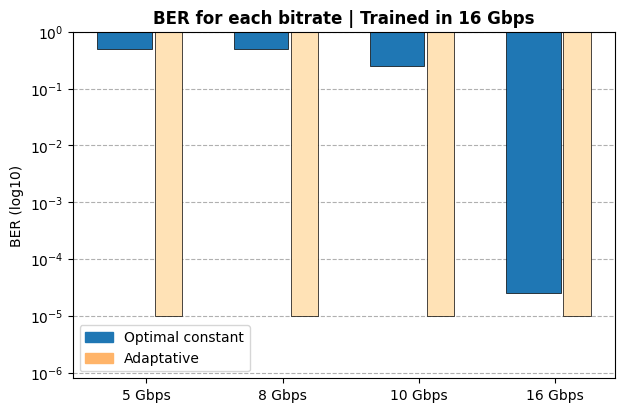

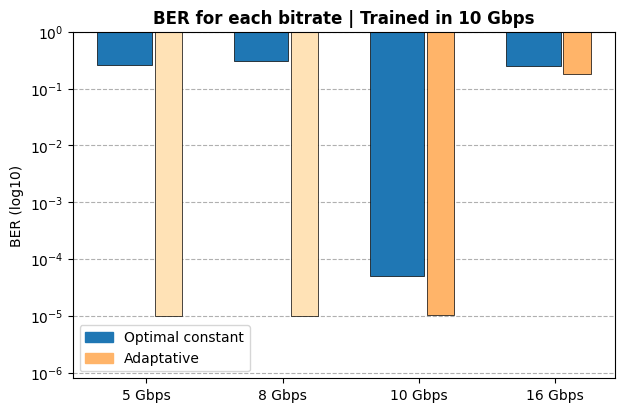

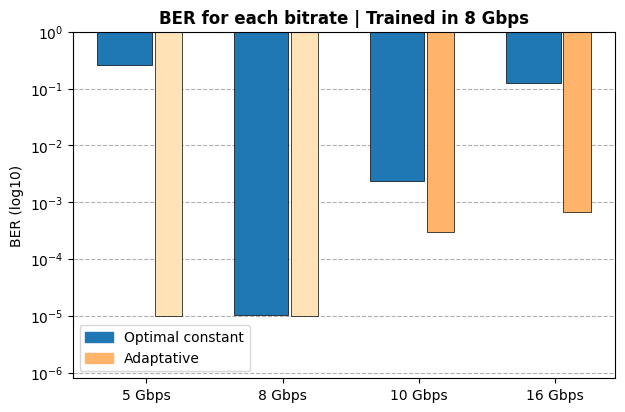

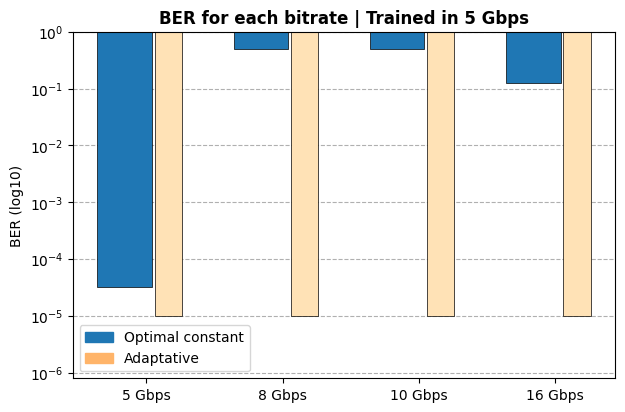

In [5]:
bitratesX = ['5 Gbps', '8 Gbps', '10 Gbps', '16 Gbps']

def cor_const(val):
    return '#1f77b4' if val > -5 else '#7CB8E1' 

def cor_adap(val):
    return "#FFB469" if val > -5 else "#FFE2B6"

for train in OptBER.keys():
    opt_vals = OptBER[train]
    adap_vals = AdapBER[train]
    
    x = np.arange(len(bitratesX))
    width = 0.4

    colors_const = [cor_const(val) for val in opt_vals]
    colors_adap = [cor_adap(val) for val in adap_vals]

    fig, ax = plt.subplots(figsize=(7, 4.5))

    ax.grid(True, linestyle='--', axis='y', zorder=0)

    desloc = width / 2.5

    ax.bar(x - desloc, opt_vals, width=width, 
           color=colors_const, edgecolor='black', linewidth=0.5, 
           label='Optimal constant', zorder=2)

    ax.bar(x + desloc, adap_vals, width=width/2, 
           color=colors_adap, edgecolor='black', linewidth=0.5, 
           label='Adaptative', zorder=2)

    ax.set_xticks(x)
    ax.set_xticklabels(bitratesX)
    ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
    ax.set_ylim([-6.1, 0])
    ax.set_ylabel('BER (log10)')
    ax.set_title(f'BER for each bitrate | Trained in {train}', fontweight="bold", fontsize=12)
    ax.legend(handles=[
        plt.Rectangle((0,0),1,1, color='#1f77b4', label='Optimal constant'),
        plt.Rectangle((0,0),1,1, color="#FFB469", label='Adaptative')
    ], fontsize=10)
    
    plt.show()

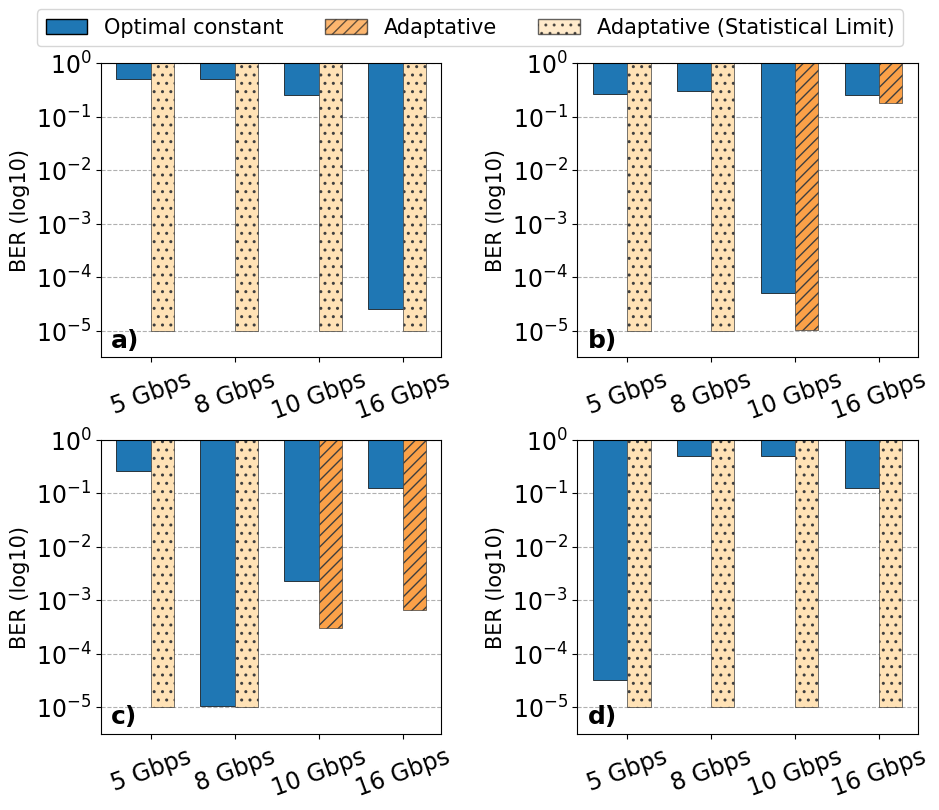

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import StrMethodFormatter
import matplotlib.patches as mpatches

labels = ['a)', 'b)', 'c)', 'd)'] 
bitratesX = ['5 Gbps', '8 Gbps', '10 Gbps', '16 Gbps']

def cor_const(val):
    return '#1f77b4' if val > -5 else '#7CB8E1'

def cor_adap(val):
    return "#FBA148" if val > -5 else "#FFE2B6"

def hatch_def(val):
    return "///" if val > -5 else ".."

fig, axes = plt.subplots(2, 2, figsize=(9.5, 8))
axes = axes.flatten()

width = 0.55 
desloc = width / 4 

for idx, train in enumerate(OptBER.keys()):
    ax = axes[idx]
    opt_vals = OptBER[train]
    adap_vals = AdapBER[train]
    
    x = np.arange(len(bitratesX))

    colors_const = [cor_const(val) for val in opt_vals]
    colors_adap = [cor_adap(val) for val in adap_vals]
    hatch_adap = [hatch_def(val) for val in adap_vals]

    ax.grid(True, linestyle='--', axis='y', zorder=0)

    ax.bar(x - desloc, opt_vals, width=width, 
           color=colors_const, edgecolor='black', linewidth=0.5, 
           label='Optimal constant', zorder=2)

    ax.bar(x + desloc, adap_vals, width=width * 0.5, 
        color=colors_adap, edgecolor='#3E3E3E', linewidth=0.5, 
        hatch=hatch_adap, 
        label='Adaptative', zorder=2)

    ax.set_xticks(x)
    ax.set_xticklabels(bitratesX, rotation=20)
    ax.yaxis.set_major_formatter(StrMethodFormatter('$10^{{{x:.0f}}}$'))
    ax.set_ylim([-5.5, 0])
    # ax.set_title(f'Trained in {train}', fontweight="bold", fontsize=11)
    ax.set_ylabel('BER (log10)',  fontsize=15)
    ax.tick_params(axis='both', labelsize=17)

    ax.text(0.03, 0.1, labels[idx], transform=ax.transAxes,
        fontsize=18, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.subplots_adjust(top=0.94,hspace=0.28,wspace=0.4)

const_patch = mpatches.Patch(facecolor='#1f77b4', edgecolor='black', label='Optimal constant')
adap_patch = mpatches.Patch(facecolor="#FC9732", edgecolor="#232323", hatch='///', alpha=0.7, label='Adaptative')
adap2_patch = mpatches.Patch(facecolor="#FFE2B6", edgecolor="#232323", hatch='..', alpha=0.7, label='Adaptative (Statistical Limit)')

fig.legend(handles=[const_patch, adap_patch, adap2_patch],
           loc='upper center', ncol=3, fontsize=15, bbox_to_anchor=(0.5, 1.02))

plt.savefig('BER_Comparison_Subplots.pdf', format='pdf', bbox_inches='tight')

plt.show()